<a href="https://colab.research.google.com/github/gyyang/neurogym/blob/master/examples/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploring NeuroGym tasks

NeuroGym is a comprehensive toolkit that allows training any network model on many established neuroscience tasks using Reinforcement Learning techniques. It includes working memory tasks, value-based decision tasks and context-dependent perceptual categorization tasks.

In this notebook we first show how to install the relevant toolbox. 

We then show how to access the available tasks and their relevant information.

Finally we train an LSTM network on the Random Dots Motion task using the A2C algorithm [Mnih et al. 2016](https://arxiv.org/abs/1602.01783) implemented in the [stable-baselines](https://github.com/hill-a/stable-baselines) toolbox, and plot the results.

You can easily change the code to train a network on any other available task or using a different algorithm (e.g. ACER, PPO2).


### Installation on google colab

In [6]:
# Install gymnasium
! pip install gymnasium
# Install neurogym
! git clone https://github.com/gyyang/neurogym.git
%cd neurogym/
! pip install -e .
# Install stable-baselines
! pip install --upgrade stable-baselines

UsageError: Line magic function `%tensorflow_version` not found.


### Explore tasks

In [3]:
import warnings
import gymnasium as gym
import neurogym as ngym
from neurogym.utils import info, plotting
warnings.filterwarnings('ignore')
info.all_tasks()

AntiReach-v0
Bandit-v0
ContextDecisionMaking-v0
DawTwoStep-v0
DelayComparison-v0
DelayMatchCategory-v0
DelayMatchSample-v0
DelayMatchSampleDistractor1D-v0
DelayPairedAssociation-v0
DualDelayMatchSample-v0
EconomicDecisionMaking-v0
GoNogo-v0
HierarchicalReasoning-v0
IntervalDiscrimination-v0
MotorTiming-v0
MultiSensoryIntegration-v0
Null-v0
OneTwoThreeGo-v0
PerceptualDecisionMaking-v0
PerceptualDecisionMakingDelayResponse-v0
PostDecisionWager-v0
ProbabilisticReasoning-v0
PulseDecisionMaking-v0
Reaching1D-v0
Reaching1DWithSelfDistraction-v0
ReachingDelayResponse-v0
ReadySetGo-v0
SingleContextDecisionMaking-v0
psychopy.RandomDotMotion-v0
psychopy.SpatialSuppressMotion-v0
psychopy.VisualSearch-v0


### Visualize a single task

<OrderEnforcing<PassiveEnvChecker<PerceptualDecisionMaking>>>


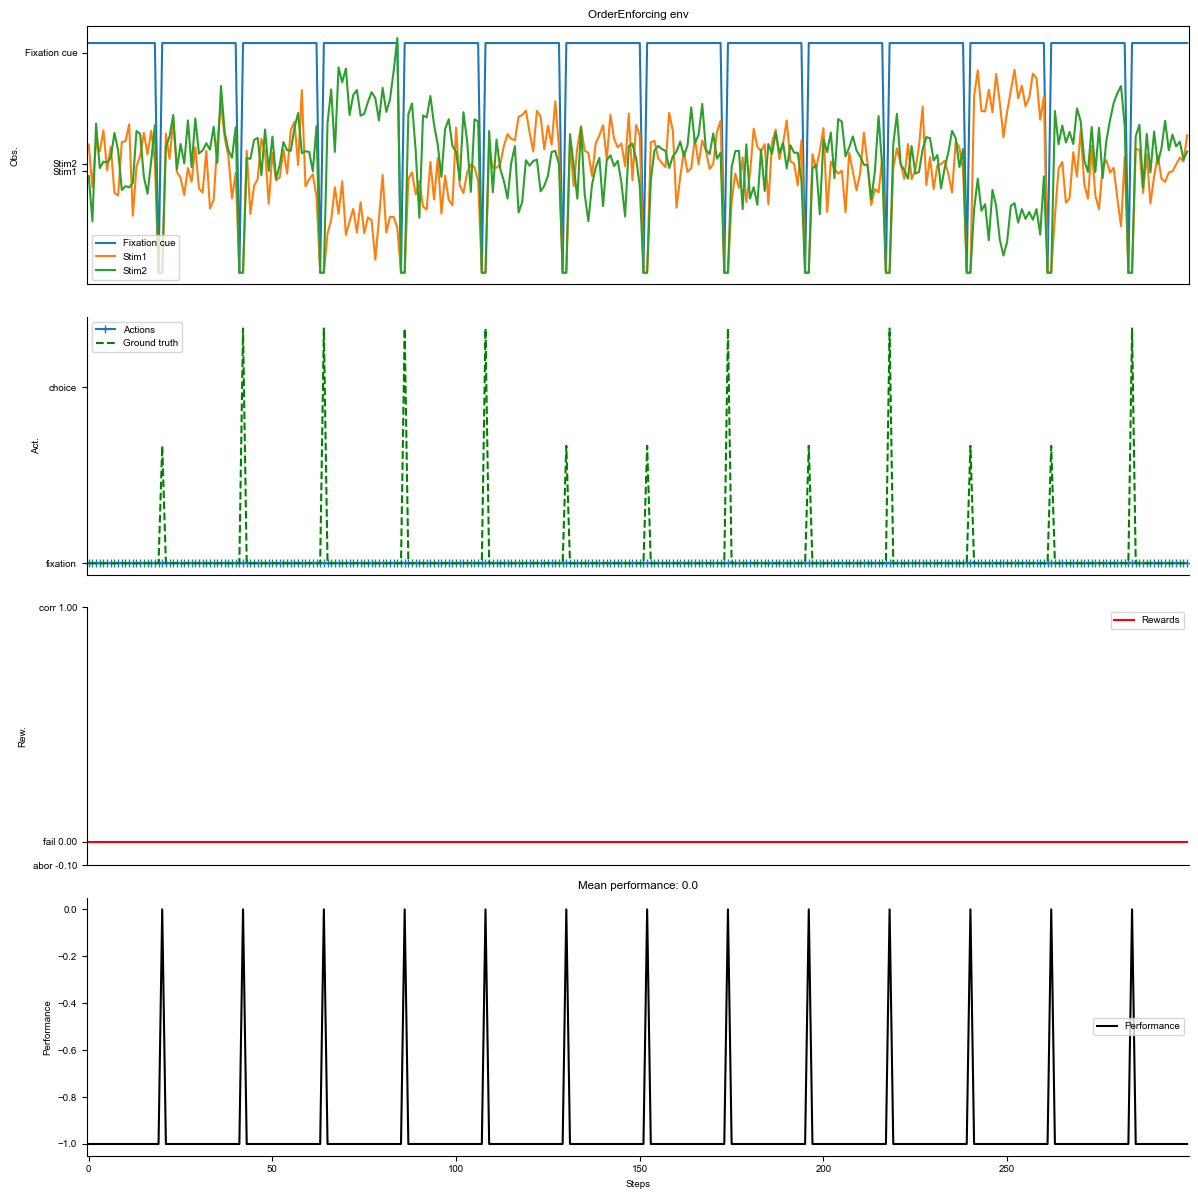

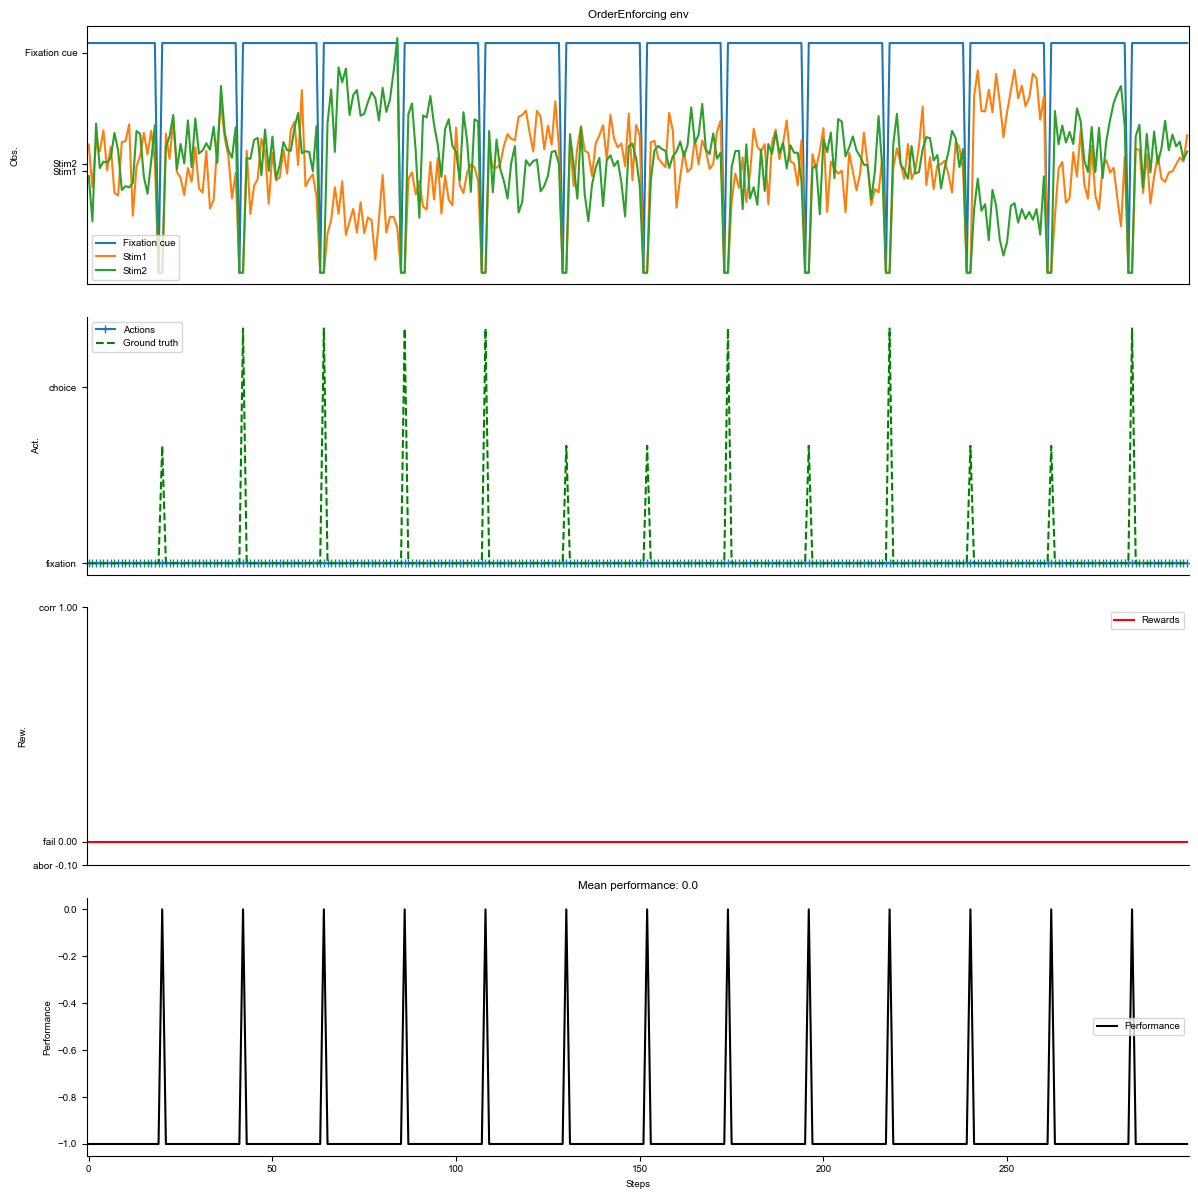

In [4]:
task = 'PerceptualDecisionMaking-v0'
env = gym.make(task)
print(env)
plotting.plot_env(env, num_steps=300, def_act=0, ob_traces=['Fixation cue', 'Stim1', 'Stim2'], fig_kwargs={'figsize': (12, 12)})

### Explore wrappers

In [3]:
info.all_wrappers()

Monitor-v0
Noise-v0
PassAction-v0
PassReward-v0
RandomGroundTruth-v0
ReactionTime-v0
ScheduleAttr-v0
ScheduleEnvs-v0
SideBias-v0
TrialHistoryV2-v0


In [4]:
info.info_wrapper('TrialHistory-v0', show_code=True)

KeyError: 'TrialHistory-v0'

### Train a network

In [5]:
import warnings
import numpy as np
from neurogym.wrappers import trial_hist, monitor
from stable_baselines.common.policies import LstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C  # ACER, PPO2
warnings.filterwarnings('default')
# task paremters
task = 'PerceptualDecisionMaking-v0'
timing = {'fixation': ('constant', 300),
          'stimulus': ('constant', 700),
          'decision': ('constant', 300)}
kwargs = {'dt': 100, 'timing': timing, 'stim_scale': 2}
# wrapper parameters
n_ch = 2
p = 0.8
num_blocks = 2
block_1 = np.array([[p, 1-p], [1-p, p]])  # repeating block
block_2 = np.array([[1-p, p], [p, 1-p]])  # alternating block
probs = np.empty((num_blocks, n_ch, n_ch))
probs[0, :, :] = block_1
probs[1, :, :] = block_2

block_dur = 50

# build task
env = gym.make(task, **kwargs)
# Apply the wrapper
env = trial_hist.TrialHistory(env, probs=probs, block_dur=block_dur)
env = monitor.Monitor(env, folder='content/tests/', sv_per=10000, verbose=1, sv_fig=True, num_stps_sv_fig=100)
# the env is now wrapped automatically when passing it to the constructor
env = DummyVecEnv([lambda: env])
model = A2C(LstmPolicy, env, verbose=1, policy_kwargs={'feature_extraction':"mlp"})
model.learn(total_timesteps=500000, log_interval=100000)
env.close()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

(2, 2, 2)




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





/home/jeremy/anaconda3/envs/neurogym/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/jeremy/anaconda3/envs/neurogym/lib/python3.7/site-packages/tensorflow_core/python/ops/variable_scope.py:452: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  shape is not None and isinstance(shape, collections_lib.Sequence) and





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | 0.178    |
| fps                | 4        |
| nupdates           | 1        |
| policy_entropy     | 1.1      |
| total_timesteps    | 5        |
| value_loss         | 0.00225  |
---------------------------------
--------------------
Number of steps:  10000.0
Average reward:  0.7333500000000001
--------------------
--------------------
Number of steps:  20000.0
Average reward:  0.83236
--------------------
--------------------
Number of steps:  30000.0
Average reward:  0.8452700000000001
--------------------
--------------------
Number of steps:  40000.0
Average reward:  0.8505
--------------------
---------------------------------
| explained_variance | 0.86     |
| fps                | 21       |
| nupdates     

### Visualize results

(2, 2, 2)


AttributeError: 'DummyVecEnv' object has no attribute 'act_dict'

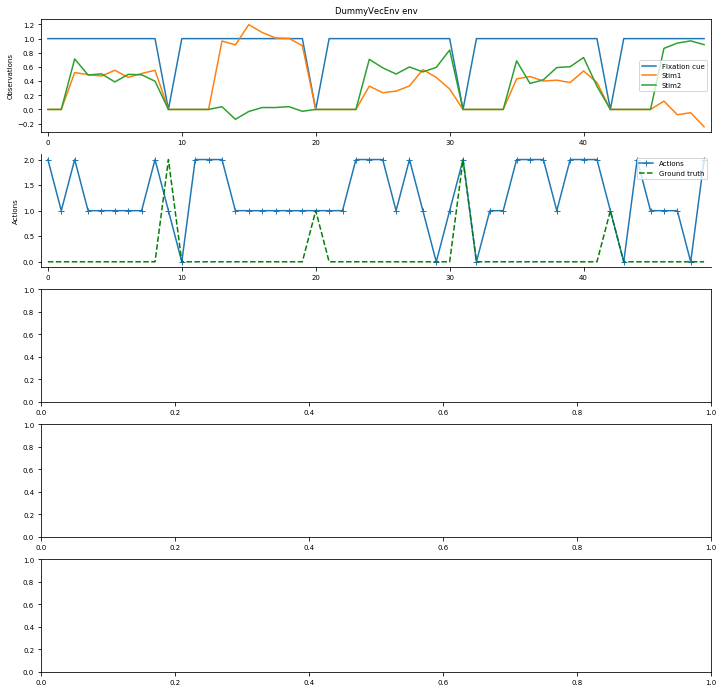

In [8]:
import numpy as np
import matplotlib.pyplot as plt
# Create task
env = gym.make(task, **kwargs)
# Apply the wrapper
env = trial_hist.TrialHistory(env, probs=probs, block_dur=block_dur)
env = DummyVecEnv([lambda: env])
plotting.plot_env(env, num_steps=50, def_act=0, ob_traces=['Fixation cue', 'Stim1', 'Stim2'], fig_kwargs={'figsize': (12, 12)}, model=model);